---
layout: default
title: "Deep Learning - CNN - Object detection"
categories: deeplearning
permalink: /ML37/
order: 37
comments: true
---

In [1]:
%pylab --no-import-all inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
from plot_ann import ann
plt.rcParams["mathtext.fontset"] = "cm"
import pandas as pd
import sklearn.datasets
from matplotlib import cm
from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib.patches import Rectangle

Populating the interactive namespace from numpy and matplotlib


# Object detection
Object detection is one of the area that has improved more in the last few years. The first step towards object detection is **object localization**.

## Object localization
Image classification is the problem of predicting the class of an object shown in a picture. A task of image classification with localization produces a predicted label for the image and also finds the exact location of the labeled object within the image. Finding the location of an object means defining a **bounding box** that contains the recognized object. Finally an object detection task detects multiple objects (even of different classes) in an image and all their locations.

To train a network on an object localization task we can build on the image classification architectures that we have seen so far. Suppose we have a network for an image classification task that needs to distinguish 3 classes: flower, leaf, background (none of the two). We would have input images, fed into a CNN with some convolutional layers and some final fully connected layers that terminates with a softmax regression layer with 3 hidden units. In order to train a network to localize the classified object we need 4 additional output units: $b_x$, $b_y$, $b_h$, $b_w$. These 4 numbers parameterize the bounding box of the detected object.

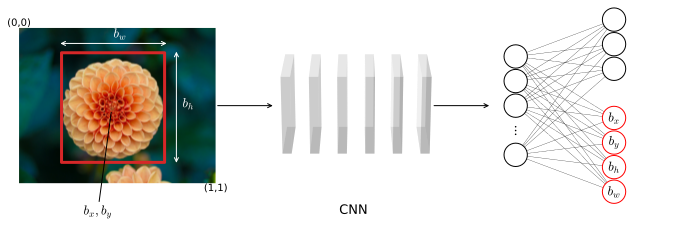

In [2]:
fig = plt.figure(figsize=(12, 4))
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], projection='3d')
ax3 = fig.add_subplot(gs[0, 2])

ax1.imshow(sklearn.datasets.load_sample_images().images[1][:, 50:-50, :])

x, y, z = np.indices((1,16,1))
l1 = (x >= 0) & (y == 0) & (z >= 0)
l2 = (x >= 0) & (y == 3) & (z >= 0)
l3 = (x >= 0) & (y == 6) & (z >= 0)
l4 = (x >= 0) & (y == 9) & (z >= 0)
l5 = (x >= 0) & (y == 12) & (z >= 0)
l6 = (x >= 0) & (y == 15) & (z >= 0)

ax2.voxels(l1 | l2 | l3 | l4 | l5 | l6, edgecolor='none', facecolors='w', alpha=.3)
ax2.set_box_aspect([1, 2, 1])
ax2.view_init(elev=20, azim=0)
ax2.text2D(0.5, 0, 'CNN', fontsize=13, transform=ax2.transAxes, ha='center', va='top')

ann([ 5, 8], ax=ax3, radius=1.9, node_labels=[*[*'   ', '$\\vdots$', *'     ', '$b_x$', '$b_y$', '$b_h$', '$b_w$']], 
    node_colors=list('kkkwkkkkwrrrr'), edge_colors=list('kkkwkkkk'*3+'w'*8+'kkkwkkkk'), node_fontsize=13)
ax3.set_aspect('equal')

ax1.annotate(' ', (0, 0), (0.47, 0.47), textcoords=ax1.transAxes, bbox=dict(boxstyle='square', pad=5, fc='none', edgecolor='C3', linewidth=3))
ax1.annotate('$b_x, b_y$', (0.47, 0.47), (0.4, -.2), xycoords=ax1.transAxes, textcoords=ax1.transAxes, ha='center', fontsize=13, arrowprops=dict(arrowstyle='-'))
ax2.annotate('', (0.1, 0.5), (1, 0.5), xycoords=ax2.transAxes, textcoords=ax1.transAxes, arrowprops=dict(arrowstyle='->'))
ax2.annotate('', (0, 0.5), (0.9, 0.5), xycoords=ax3.transAxes, textcoords=ax2.transAxes, arrowprops=dict(arrowstyle='->'))
ax1.text(0, 1, '(0,0)', va='bottom', ha='center', transform=ax1.transAxes)
ax1.text(1, 0, '(1,1)', va='top', ha='center', transform=ax1.transAxes)
h = ax1.annotate('', (0.8, 0.12), (0.8, 0.86), xycoords=ax1.transAxes, textcoords=ax1.transAxes, arrowprops=dict(arrowstyle='<->', edgecolor='w'))
ax1.annotate('$b_h$', (0, 0), (2, 0.5), textcoords=h.arrow_patch, fontsize=13, c='w')
w = ax1.annotate('', (0.2, 0.9), (0.76, 0.9), xycoords=ax1.transAxes, textcoords=ax1.transAxes, arrowprops=dict(arrowstyle='<->', edgecolor='w'))
ax1.annotate('$b_w$', (0, 0), (0.5, 2), textcoords=w.arrow_patch, fontsize=13, c='w')

for ax in [ax1, ax2, ax3]:
    ax.set_axis_off()

<i id="fig:cnnloc">Simplified architecture of a CNN trained on a task of object localization. It takes as input an image, whose representation passes through some convolutional layers and finally to some densely connected layers. The output layers has 4 units dedicated to parameterize the bounding box for localization, with $b_x$, $b_y$ (the coordinates of the midpoint of the bounding box) and $b_w$, $b_h$ (the width and height of the bounding box)</i>

A CNN trained on a localization task needs a labeled training set with the four parameters of the bounding box defined for each example. In particular the label vector $y$ will be:

$$
y=
\begin{bmatrix}
p_c \\
b_x \\ 
b_y \\
b_h \\
b_w \\
c_1 \\
c_2
\end{bmatrix}
$$

where $p_c$ is the probability that the picture contains an object (either 1 or 0), $b_x, b_y, b_w, b_h$ are the parameters of the bounding box and $c_1$ and $c_2$ are 1 if the object in the picture is class 1 or 2 respectively, otherwise they are 0. When $p_c=0$ we can ignore all other values of the label vector $y$, since the only feature that we care to learn is that in that image there is no object. This is reflected in the loss function $\mathcal{L}(\hat{y},y)$

$$
\mathcal{L}(\hat{y},y)=
\begin{cases} 
\sum_{i=1}^{c+4}(\hat{y}_i - y_i)^2 & \text{if } y_i = 1 \\
(\hat{y}_i - y_i)^2   & \text{if } y_i = 0 \\
\end{cases}
$$

Here squared error loss function is used for all labels where in reality squared error is used for the bounding box labels and $p_c$, while for the 2 class labels log loss is usually employed although probably using squared error would work just fine.

## Landmark detection
By expanding object localization to a more general case, we can train a neural network to output $x,y$ coordinates of relevant points (**landmarks**) in an image. Suppose we are building a face recognition application and we want to identify some important features of a face, as for example the eyes and the mouth. To train a network on the task to recognize these landmarks, the label vector $y$ would contain the eyes coordinates and mouth coordinates.

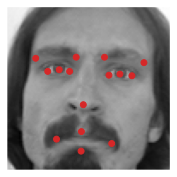

In [3]:
images = pd.read_csv('data/face_landmarks.csv', nrows=10, index_col=[0])
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(np.array(images.Image.values[0].split(), dtype=float).reshape(96, 96, 1), cmap='gray')
xy = images.drop('Image', axis=1).loc[0]
ax.plot(xy[::2], xy[1::2], ls='none', marker='o', c='C3')
ax.set_axis_off()

<i id="fig:landmarks">Some face landmarks drawn in red over a grayscale face picture</i>

Obviously, in order to train a neural network to output landmark coordinates it has to be trained on a labeled dataset, which needs to be laboriously and precisely annotated for each landmark in each picture. 

In <a href="#fig:landmarks">the figure above</a> we can see a typical set of landmarks for face-oriented tasks. Another example of landmark detection not applyed to face pictures is pose detection where landmarks usually reflect body joints (e.g. shoulder, knee) that, connected toghether, form a sort of skeleton of a person.

## Object detection
A convnet can be trained on object detection using a technique called **sliding window detection**. Suppose we want to train an algorithm for a self-driving car, which should be able to detect multiple type of objects and multiple instances of objects in a picture (<a href="fig:cardetect">figure below</a>).

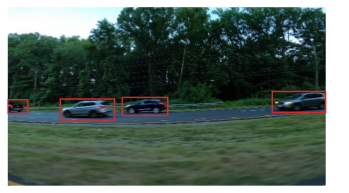

In [4]:
fig, ax = plt.subplots()
img = plt.imread('./data/img/vid_4_9620.jpg')
ax.imshow(img)
ax.set_axis_off()

bbox = pd.read_csv('./data/bbox.csv', index_col=0)
for row in bbox.loc['vid_4_9620.jpg'].iterrows():
    ax.plot(row[1][['xmin', 'xmin', 'xmax', 'xmax', 'xmin']],
            row[1][['ymin', 'ymax', 'ymax', 'ymin', 'ymin']], c='C3')

<i id="fig:cardetect">A frame of a video-feed with multiple cars correctly localized by an  object detection algorithm</i>

In order to obtain an object detection capable neural network, we need to train it on a training where each example is a picture of a closely cropped car (<a href="fig:objdettrainset">figure below</a>) and the label simply tells if the picture contains a car or not. 

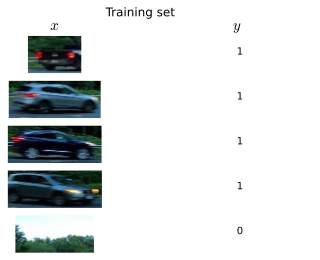

In [5]:
fig, axes = plt.subplots(5, 2)
fig.suptitle('Training set')
img = plt.imread('./data/img/vid_4_9620.jpg')
bbox = pd.read_csv('./data/bbox.csv', index_col=0)

axes[0, 0].set_title('$x$', fontsize=15)
for ax, row in zip(axes[:, 0], bbox.loc['vid_4_9620.jpg'].iterrows()):
    ax.imshow(img)
    ax.set_axis_off()
    ax.set_xlim(*row[1][['xmax', 'xmin']])
    ax.set_ylim(*row[1][['ymax', 'ymin']])

axes[-1, 0].imshow(img)
axes[-1, 0].set_xlim(200, 0)
axes[-1, 0].set_ylim(100, 5)
axes[-1, 0].set_axis_off()

    
axes[0, 1].set_title('$y$', fontsize=15)
for ax in axes[:-1, 1]:
    ax.set_axis_off()
    ax.text(0.5, 0.5, '1')
axes[-1, 1].text(0.5, 0.5, '0')
axes[-1, 1].set_axis_off()

<i id="fig:objdettrainset">Training set for an object detection algorithm with closely cropped images of the object of interest</i>

The next step, would be to train a CNN that takes as input a picture and tells if the picture is  a car $\hat{y}=1$ or not $\hat{y}=0$. Once trained, this CNN is used in a **sliding window detection** system, the CNN is fed an image bound by a box that rolls over the image from left to right and from top to bottom. While in <a href="#fig:slidingwindow">the figure below</a> a rather large stride is used in reality the stride is small enough to be able to pass to the CNN each portion of the image that can contain a car and so the stride will be much smaller. The process of rolling the window over the whole image is repeated with windows of different sizes

In [6]:
%%capture
fig = plt.figure(figsize=(10, 4), dpi=100)
ax1 = fig.add_axes([0, 0, .6, 1])
ax2 = fig.add_axes([.55, .52, 0.4, 0.4], xticks=[], yticks=[])

img = plt.imread('./data/img/vid_4_9620.jpg')
h, w, _ = img.shape
im = ax1.imshow(img)
h_steps = 8
w_steps = 8
r = Rectangle((0, 0), w/w_steps, h/h_steps, facecolor='none', edgecolor='r', linewidth=2)
p = np.zeros((h_steps, w_steps))
p[4, :4] = 1
p[4, 7] = 1
p = p.reshape(h_steps*w_steps)
t = ax2.text(0.5, -.5, '$\\mathrm{{CNN}} \\; \\to \\; y={}$'.format(int(p[0])), va='center', ha='left', transform=ax2.transAxes, fontsize=15)
ax2.annotate('', (0.54, 0), (0.1, 1.1), xycoords=ax2.transAxes, textcoords=t, arrowprops=dict(arrowstyle='<-'))
ax1.set_axis_off()

In [7]:
def init():
    ax1.add_artist(r)
    ax2.imshow(img)
    plt.setp(ax2.spines.values(), color='r', linewidth=2)
    
    return [r]
def animate(i):
    x = (w/w_steps) * (i)
    y = (h/h_steps) * (x//w)
    x %= w
    r.set_xy((x, y))
    ax2.set_xlim(x, x+w/w_steps)
    ax2.set_ylim(y+h/h_steps, y)
    t.set_text('$\\mathrm{{CNN}} \\; \\to \\; y={}$'.format(int(p[i])))
    return [r]

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=h_steps * w_steps, interval=200, 
                               blit=True)

HTML(anim.to_html5_video())

<i id="fig:slidingwindow">A sliding window system with a box (window) sliding through an image used as a bounding box for producing crops of the image that cover its entirety. These crops are fed into a specialized CNN that evaluates the presence $y=1$ or absence $y=0$ of an object.</i>

An approach like that described above would have a huge computational cost. In general, sliding window detection systems are very computationally heavy, since you need to run the model for each crop produced by the sliding window. So, with a small enough stride to have an acceptable granularity and an adequate number of window sizes, the number of prediction would be very large. When the sliding window technique was invented, the models run through each step were mostly linear, so the computational cost could be contained, but running a CNN this many times would take too much time for a real time application like that needed by a self-driving system. In order to surpass this issue, a convolutional implementation of the sliding window is employed in place of this traditional implementation.

## Convolutional implementation of the sliding window
The classic implementation of the sliding window would be too slow if the function applied to the sliding window is a CNN. The convolutional implementation of the sliding window is much more efficient. To build towards it let's explore how to convert fully connected layers into convolutional layers. Suppose you have a CNN as in panel A of <a href="#fig:">the figure below</a>, with some convolutional early layers and some fully connected late layers. In order to convert the fully connected layers to a convolutional representation, a number of filters ($=n_c^{[l]} = w^{[l]} = h^{[l]}$, that will perform a single step of convolution (thus stride is irrelevant) with the whole input volume (<a href="#fig:">the figure below</a>, panel B). The output volume of all these filters will have the dimensions $1 \times 1 \times n_c^{[l]}$. By following this strategy all fully connected layers can be converted to convolutional representations with the same number of units as their fully connected counterparts.

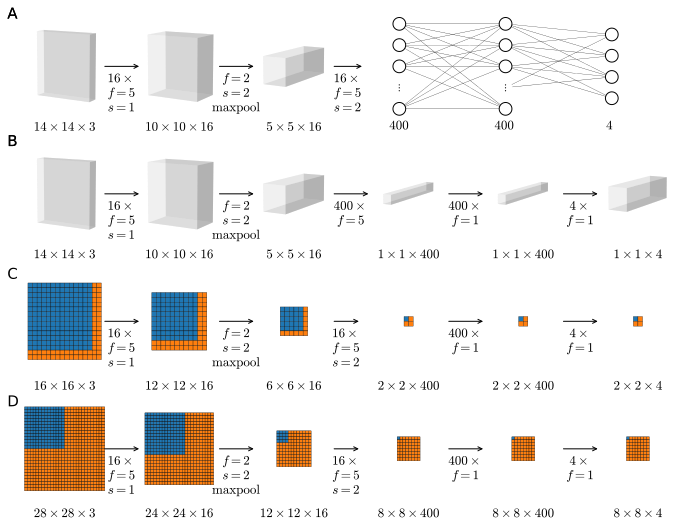

In [21]:
fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(4, 6, )
ax1 = fig.add_subplot(gs[0, 0], projection='3d')
ax2 = fig.add_subplot(gs[0, 1], projection='3d')
ax3 = fig.add_subplot(gs[0, 2], projection='3d')
ax4 = fig.add_subplot(gs[0, 3:])
ax5 = fig.add_subplot(gs[1, 0], projection='3d')
ax6 = fig.add_subplot(gs[1, 1], projection='3d')
ax7 = fig.add_subplot(gs[1, 2], projection='3d')
ax8 = fig.add_subplot(gs[1, 3], projection='3d')
ax9 = fig.add_subplot(gs[1, 4], projection='3d')
ax10 = fig.add_subplot(gs[1, 5], projection='3d')
ax11 = fig.add_subplot(gs[2, 0])
ax12 = fig.add_subplot(gs[2, 1])
ax13 = fig.add_subplot(gs[2, 2])
ax14 = fig.add_subplot(gs[2, 3])
ax15 = fig.add_subplot(gs[2, 4])
ax16 = fig.add_subplot(gs[2, 5])
ax17 = fig.add_subplot(gs[3, 0])
ax18 = fig.add_subplot(gs[3, 1])
ax19 = fig.add_subplot(gs[3, 2])
ax20 = fig.add_subplot(gs[3, 3])
ax21 = fig.add_subplot(gs[3, 4])
ax22 = fig.add_subplot(gs[3, 5])

x, y, z = np.indices((1,1,1))
voxels = (x >= 0) & (y >= 0) & (z >= 0)

def first_layers(ax1, ax2, ax3):
    ax1.voxels(voxels, edgecolor='none', facecolors='w', alpha=.3)
    ax1.set_box_aspect([14, 3, 14])
    ax1.text2D(0.5, -.07, '$14 \\times 14 \\times 3$', fontsize=13, transform=ax1.transAxes, ha='center', va='top')

    ax2.voxels(voxels, edgecolor='none', facecolors='w', alpha=.3)
    ax2.set_box_aspect([10, 6, 10])
    ax2.text2D(0.5, -.07, '$10 \\times 10 \\times 16$', fontsize=13, transform=ax2.transAxes, ha='center', va='top')

    ax3.voxels(voxels, edgecolor='none', facecolors='w', alpha=.3)
    ax3.set_box_aspect([5, 16, 5])
    ax3.text2D(0.5, -.07, '$5 \\times 5 \\times 16$', fontsize=13, transform=ax3.transAxes, ha='center', va='top')
    
    w1 = plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax1.transAxes, textcoords=ax2.transAxes, arrowprops=dict(arrowstyle='<-'))
    plt.annotate('$16 \\times$\n$f=5$\n$s=1$', xy=(0, 0), xytext=(0.5, -1), xycoords=w1.arrow_patch, ha='center', va='top', fontsize=13)
    w2 = plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax2.transAxes, textcoords=ax3.transAxes, arrowprops=dict(arrowstyle='<-'))
    plt.annotate('$f=2$\n$s=2$\n$\\mathrm{maxpool}$', xy=(0, 0), xytext=(0.5, -1), xycoords=w2.arrow_patch, ha='center', va='top', fontsize=13)

first_layers(ax1, ax2, ax3)
ann([5, 5, 4], ax=ax4, radius=1, width=3, node_labels=[*[*'   ', '$\\vdots$', ' ']*2], node_colors=list('kkkwk')*2, edge_colors=list('kkkwkkkkwkkkkwkwwwwwkkkwk'*2))
# ax4.text(0, 0, '$400 \\qquad \\qquad 400 \\qquad  \\quad 4$', fontsize=13, transform=ax4.transAxes, ha='left', va='top')
ax4.text(0.11, 0, '$400$', fontsize=13, transform=ax4.transAxes, ha='center', va='top')
ax4.text(0.44, 0, '$400$', fontsize=13, transform=ax4.transAxes, ha='center', va='top')
ax4.text(0.77, 0, '$4$', fontsize=13, transform=ax4.transAxes, ha='center', va='top')

ax4.set_aspect('equal')
w3 = plt.annotate('', (.9, 0.5), (0, 0.5), xycoords=ax3.transAxes, textcoords=ax4.transAxes, arrowprops=dict(arrowstyle='<-'))
plt.annotate('$16 \\times$\n$f=5$\n$s=2$', xy=(0, 0), xytext=(0.5, -1), xycoords=w3.arrow_patch, ha='center', va='top', fontsize=13)


first_layers(ax5, ax6, ax7)

ax8.voxels(voxels, edgecolor='none', facecolors='w', alpha=.3)
ax8.set_box_aspect([1, 10, 1])
ax8.text2D(0.5, -.07, '$1 \\times 1 \\times 400$', fontsize=13, transform=ax8.transAxes, ha='center', va='top')
w2 = plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax7.transAxes, textcoords=ax8.transAxes, arrowprops=dict(arrowstyle='<-'))
plt.annotate('$400 \\times$\n$f=5$', xy=(0, 0), xytext=(0.5, -1), xycoords=w2.arrow_patch, ha='center', va='top', fontsize=13)

ax9.voxels(voxels, edgecolor='none', facecolors='w', alpha=.3)
ax9.set_box_aspect([1, 10, 1])
ax9.text2D(0.5, -.07, '$1 \\times 1 \\times 400$', fontsize=13, transform=ax9.transAxes, ha='center', va='top')
w2 = plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax8.transAxes, textcoords=ax9.transAxes, arrowprops=dict(arrowstyle='<-'))
plt.annotate('$400 \\times$\n$f=1$', xy=(0, 0), xytext=(0.5, -1), xycoords=w2.arrow_patch, ha='center', va='top', fontsize=13)

ax10.voxels(voxels, edgecolor='none', facecolors='w', alpha=.3)
ax10.set_box_aspect([1, 4, 1])
ax10.text2D(0.5, -.07, '$1 \\times 1 \\times 4$', fontsize=13, transform=ax10.transAxes, ha='center', va='top')
w2 = plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax9.transAxes, textcoords=ax10.transAxes, arrowprops=dict(arrowstyle='<-'))
plt.annotate('$4 \\times$\n$f=1$', xy=(0, 0), xytext=(0.5, -1), xycoords=w2.arrow_patch, ha='center', va='top', fontsize=13)


for ax in [ax1, ax2, ax3, ax5, ax6, ax7, ax8, ax9, ax10]:
    ax.view_init(elev=10, azim=-60)
    ax.set_axis_off()

def tabpad(ax, shape, pad, label=None, scale=.3):
    l1 = np.full(shape, 'C0')
    l1[:, -pad:] = 'C1'
    l1[-pad:, :] = 'C1'
    
    tab = ax.table(np.full(shape, ''), loc='center', colWidths=[0.12]*shape[0], cellLoc='center', cellColours=l1, alpha=.6)
    tab.scale(scale, scale)
    if label is not None:
        ax.text(0.5, -.05, label, va='top', ha='center', transform=ax.transAxes, fontsize=13)
        
    ax.set_axis_off()
    
    canvas = tab.get_celld()
    for i in range(shape[0]):
        for j in range(shape[1]):
            canvas[i, j].set_linewidth(.3)

tabpad(ax11, (16, 16), 2, label='$16\\times 16 \\times 3$', scale=.4)
tabpad(ax12, (12, 12), 2, label='$12\\times 12 \\times 16$', scale=.4)
tabpad(ax13, (6, 6), 1, label='$6\\times 6 \\times 16$', scale=.4)
tabpad(ax14, (2, 2), 1, label='$2\\times 2 \\times 400$', scale=.4)
tabpad(ax15, (2, 2), 1, label='$2\\times 2 \\times 400$', scale=.4)
tabpad(ax16, (2, 2), 1, label='$2\\times 2 \\times 4$', scale=.4)

w1 = plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax11.transAxes, textcoords=ax12.transAxes, arrowprops=dict(arrowstyle='<-'))
plt.annotate('$16 \\times$\n$f=5$\n$s=1$', xy=(0, 0), xytext=(0.5, -1), xycoords=w1.arrow_patch, ha='center', va='top', fontsize=13)
w2 = plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax12.transAxes, textcoords=ax13.transAxes, arrowprops=dict(arrowstyle='<-'))
plt.annotate('$f=2$\n$s=2$\n$\\mathrm{maxpool}$', xy=(0, 0), xytext=(0.5, -1), xycoords=w2.arrow_patch, ha='center', va='top', fontsize=13)
w3 = plt.annotate('', (.9, 0.5), (0, 0.5), xycoords=ax13.transAxes, textcoords=ax14.transAxes, arrowprops=dict(arrowstyle='<-'))
plt.annotate('$16 \\times$\n$f=5$\n$s=2$', xy=(0, 0), xytext=(0.5, -1), xycoords=w3.arrow_patch, ha='center', va='top', fontsize=13)
w4 = plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax14.transAxes, textcoords=ax15.transAxes, arrowprops=dict(arrowstyle='<-'))
plt.annotate('$400 \\times$\n$f=1$', xy=(0, 0), xytext=(0.5, -1), xycoords=w4.arrow_patch, ha='center', va='top', fontsize=13)
w5 = plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax15.transAxes, textcoords=ax16.transAxes, arrowprops=dict(arrowstyle='<-'))
plt.annotate('$4 \\times$\n$f=1$', xy=(0, 0), xytext=(0.5, -1), xycoords=w5.arrow_patch, ha='center', va='top', fontsize=13)

tabpad(ax17, (28, 28), 14, label='$28\\times 28 \\times 3$', scale=.25)
tabpad(ax18, (24, 24), 10, label='$24\\times 24 \\times 16$', scale=.25)
tabpad(ax19, (12, 12), 8, label='$12\\times 12 \\times 16$', scale=.25)
tabpad(ax20, (8, 8), 7, label='$8\\times 8 \\times 400$', scale=.25)
tabpad(ax21, (8, 8), 7, label='$8\\times 8 \\times 400$', scale=.25)
tabpad(ax22, (8, 8), 7, label='$8\\times 8 \\times 4$', scale=.25)

w1 = plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax17.transAxes, textcoords=ax18.transAxes, arrowprops=dict(arrowstyle='<-'))
plt.annotate('$16 \\times$\n$f=5$\n$s=1$', xy=(0, 0), xytext=(0.5, -1), xycoords=w1.arrow_patch, ha='center', va='top', fontsize=13)
w2 = plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax18.transAxes, textcoords=ax19.transAxes, arrowprops=dict(arrowstyle='<-'))
plt.annotate('$f=2$\n$s=2$\n$\\mathrm{maxpool}$', xy=(0, 0), xytext=(0.5, -1), xycoords=w2.arrow_patch, ha='center', va='top', fontsize=13)
w3 = plt.annotate('', (.9, 0.5), (0, 0.5), xycoords=ax19.transAxes, textcoords=ax20.transAxes, arrowprops=dict(arrowstyle='<-'))
plt.annotate('$16 \\times$\n$f=5$\n$s=2$', xy=(0, 0), xytext=(0.5, -1), xycoords=w3.arrow_patch, ha='center', va='top', fontsize=13)
w4 = plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax20.transAxes, textcoords=ax21.transAxes, arrowprops=dict(arrowstyle='<-'))
plt.annotate('$400 \\times$\n$f=1$', xy=(0, 0), xytext=(0.5, -1), xycoords=w4.arrow_patch, ha='center', va='top', fontsize=13)
w5 = plt.annotate('', (.9, 0.5), (.1, 0.5), xycoords=ax21.transAxes, textcoords=ax22.transAxes, arrowprops=dict(arrowstyle='<-'))
plt.annotate('$4 \\times$\n$f=1$', xy=(0, 0), xytext=(0.5, -1), xycoords=w5.arrow_patch, ha='center', va='top', fontsize=13)


ax1.text2D(-.1, 1, 'A', transform=ax1.transAxes, fontsize=15)
ax5.text2D(-.1, 1, 'B', transform=ax5.transAxes, fontsize=15)
ax11.text(-.1, .9, 'C', transform=ax11.transAxes, fontsize=15)
ax1.text2D(-.1, 1, 'A', transform=ax1.transAxes, fontsize=15)
ax5.text2D(-.1, 1, 'B', transform=ax5.transAxes, fontsize=15)
ax16.text(-.1, .9, 'D', transform=ax17.transAxes, fontsize=15);

<i id="fig:convslidingwin">A Classic CNN that takes as input a $14 \times 14 \times 3$ image, with a few convolutional early layers and some final fully connected layers (A); the same network with fully connected layers converted in convolutional volumes with the same number of units of their fully connected counterparts (B); A slightly bigger input than anticipated ($16 \times 16 \times 3$) is fed to the network in panel B (surplus shown as orange cells) and how the surplus propagates in the network (C)</i>

Suppose we have a classic CNN (<a href="#fig:convslidingwin">figure above</a>, panel A) where FC layers are converted to CONV layers (<a href="#fig:convslidingwin">figure above</a>, panel B). Suppose that this network takes as input $14 \times 14 \times 3$ images and outputs a $1 \times 1 \times 4$ volume. This networks expects a $14 \times 14$ image and, when fed a larger image, let's say $16 \times 16$ (<a href="#fig:convslidingwin">figure above</a>, panel C). It can be shown that by running your larger input image, $16 \times 16$ in this case,  through all the layers of the CNN designed for the $14 \times 14$, you will end up with a larger output volume $2 \times 2 \times 4$ in this case, where each cell corresponds to the output of the CNN for a each $14 \times 14$ window in the input image. In this case the top-left cell of the $2 \times 2$ output corresponds to the output of the CNN on a $14 \times 14$ window in the top-left corner of the input image (in blue in <a href="#fig:convslidingwin">figure above</a>, panel C); Analogously, the top-right corner in the output volume corresponds to a window in the top-right corner of the input image; and so on.

We can visualize how the activations values of a $14 \times 14$ window propagate across the CNN layers in panel C of <a href="#fig:convslidingwin">figure above</a>. The blue portion of the volume face in the $16 \times 16$ input will activate exactly the blue windows in all the other layers up to the blue portion of the output layer. By Moving the blue window with a stride $s=2$ to the right we will produce the top-right corner in the output layer and the same applies for the bottom left and the bottom right blue windows producing the bottom left and bottom right output cells, respectively

Instead of running the CNN $n$ times on $n$ windows of the input image and independently produce $n$ predictions, this implementation combines all forward-propagations in 1 single computation, it shares most of the computations in the regions that are common to all $n$ windows and outputs $n$ predictions. 

In panel C of <a href="#fig:convslidingwin">figure above</a> we used a $16 \times 16$ input image but the same applies to a bigger input: A $28 \times 28 \times 3$ fed to the same CNN will output an $8 \times 8 \times 4$ output (<a href="#fig:convslidingwin">figure above</a>, panel D), which corresponds to running a $14 \times 14$ sliding window with a stride $s=2$ across the input image; the stride $s=2$ that we cited for both examples in panels C and D of <a href="#fig:convslidingwin">figure above</a> is defined by the $f=2$ of the max-pooling layer.

One of the problems of this approach is that the position of the bounding boxes is not going to be accurate. This problem can be fixed with an approach called **YOLO**